### Density calculations for figure 4

In [1]:
from brokenaxes import brokenaxes
import cmocean as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib.patches as patches
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pickle
import scipy as sc
import scipy.io as sio
import seawater as sw
from scipy.interpolate import griddata
import xarray as xr

%matplotlib inline

In [7]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density in the water column using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be either arrays or scalars (if arrays, in coordinate order (...,Z, Y , X )) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...]) + beta*(S[...]))
    return rho

def calc_N2(RhoRef,rho,drC):
    '''INPUT:
    RhoRef: same as in calc_rho, reference density (scalar)
    rho: density (1D array size nz)
    drC: vertical spacing between cell centers (1D array size nz+1)
    OUTPUT:
    N2: buoyancy frequency squared (1D array size nz-2)'''
    
    g = 9.81 # m/s^2
    N2 = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(-drC[2:]-drC[:-2])))            
    return(N2)

def mean_rho_shelf(ds, y1, y2, xind, xend, thresh=-150, bathy_flag='canyon'):
    '''Calculate volume-weighted mean density on the shelf'''
    
    mask = np.ma.getmask(np.ma.masked_less_equal(ds.z_rho[:,:,y1:y2,xind:xend],thresh))

    with open('box_rho_'+run+'.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
        rho_box, rho_box_nc, time = pickle.load(f)
    if bathy_flag == 'no canyon':
        rho_shelf = np.ma.masked_array(rho_box_nc, mask=mask)
    else:     
        rho_shelf = np.ma.masked_array(rho_box, mask=mask)
        
    #x-spacing
    dx =  np.expand_dims(np.expand_dims(np.expand_dims(ds.x_u[y1,xind:xend].data-
                                        ds.x_u[y1,xind-1:xend-1].data,axis=0), axis=0),axis=0)
    dx_exp = dx + np.zeros_like(rho_shelf)
    
    #y-spacing
    dy =  np.expand_dims(np.expand_dims(np.expand_dims(ds.y_u[y1-1:y2-1,xind].data-
                                        ds.y_u[y1:y2,xind].data,axis=1), axis=0), axis=0)
    dy_exp = dy + np.zeros_like(rho_shelf)
    
    #z-spacing
    dz = -(ds.z_w[:,:-1,y1:y2,xind:xend].data-ds.z_w[:,1:,y1:y2,xind:xend].data)
                                    
    # cell volumes
    dv = dx_exp * dy_exp * dz
    
    # volume-weighted avg
    rho_avg = (np.nansum(np.nansum(np.nansum(dv*rho_shelf, axis=1),axis=1),axis=1)/
               np.nansum(np.nansum(np.nansum(dv, axis=1), axis=1),axis=1))
    return(rho_avg)
    
def calc_delta_rho(ds, ds_nc, y1, y2, xind, xend):
    '''Calculate \delta rho on shelf (canyon - no canyon)'''
    rho_canyon = mean_rho_shelf(ds,y1, y2, xind, xend, thresh=-150)  
    rho_nocan = mean_rho_shelf(ds_nc,y1, y2, xind, xend, thresh=-150, bathy_flag='no canyon')                                   
    return((rho_canyon-rho_nocan)-(rho_canyon-rho_nocan)[0])


In [9]:
runs = ['DS','IS','SS']

col1 = '#254441' 
col2 = '#43AA8B' 
col3 = '#B2B09B' 
colors = [col1, col2, col3]

## Density alongshore sections
y1 = 139 # -30 km canyon axis
y2 = 439 # +30 km canyon axix 
y_axis = 289 # canyon axis
x1 = 239 # -10 km
x2 = 264 # -5 km
x3 = 188
xend = 289
t1 = 90
t2 = 195
t_low = 140
t_high = 157
nz = 30
S0 = 35.0 

In [10]:
for run in runs:
    file = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_'+run+'_7d.nc'
    ds = xr.open_dataset(file, decode_times=False)

    file2 = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_NCR_'+run+'_7d.nc'
    ds_nc = xr.open_dataset(file2, decode_times=False)

    time = ds.ocean_time[:]/(3600*24)
    nt = len(time)
    rho_box = np.zeros((nt, nz, y2-y1, xend-x3))   
    rho_box_nc = np.zeros((nt, nz, y2-y1, xend-x3))   

    for tt in range(nt):
        for zz in range(nz):
            temp = ds.temp[tt,zz,y1:y2,x3:xend]
            temp_nc = ds_nc.temp[tt,zz,y1:y2,x3:xend]
            rho_box[tt,zz,:,:] = sw.pden(S0*np.ones_like(temp),
                                         temp,
                                         -ds.z_rho[tt,zz,y1:y2,x3:xend],0)-1000.0
            rho_box_nc[tt,zz,:,:] = sw.pden(S0*np.ones_like(temp),
                                            temp_nc,
                                            -ds_nc.z_rho[tt,zz,y1:y2,x3:xend],0)-1000.0
        
    with open('box_rho_'+run+'.pkl', 'wb') as f:  
        pickle.dump([rho_box,rho_box_nc,time], f)


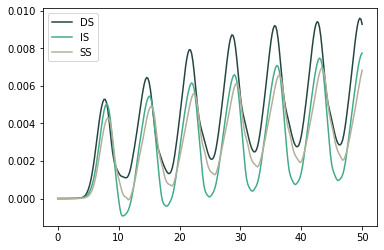

In [11]:
fig, ax = plt.subplots(1,1)
runs = ['DS','IS','SS']
for run, col in zip(runs,colors):
    file = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_'+run+'_7d.nc'
    ds = xr.open_dataset(file, decode_times=False)

    file2 = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_NCR_'+run+'_7d.nc'
    ds_nc = xr.open_dataset(file2, decode_times=False)

    canyon_mask = np.ma.getmask(np.ma.masked_less(ds.z_rho[:,:,y1:y2,x3:xend],-150))
    nocanyon_mask = np.ma.getmask(np.ma.masked_less(ds_nc.z_rho[:,:,y1:y2,x3:xend],-150))
    
    with open('box_rho_'+run+'.pkl', 'rb') as f:  
        rho_box, rho_box_nc, time = pickle.load(f)
    mean_rho = np.nanmean(np.nanmean(np.nanmean(np.ma.masked_array(rho_box,
                                                                   mask=canyon_mask),axis=1),axis=1),axis=1)
    mean_rho_nc = np.nanmean(np.nanmean(np.nanmean(np.ma.masked_array(rho_box_nc,
                                                                      mask=nocanyon_mask),axis=1),axis=1),axis=1)
    delta_rho = calc_delta_rho(ds, ds_nc, y1, y2, x3, xend)
    ax.plot(time, delta_rho, label=run, color=col)
    with open('delta_rho_shelf_wa_'+run+'.pkl', 'wb') as g:  
        pickle.dump([delta_rho,time], g)

ax.legend()